In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.ghostnetv2 import GhostNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/ghostnetv2")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

31


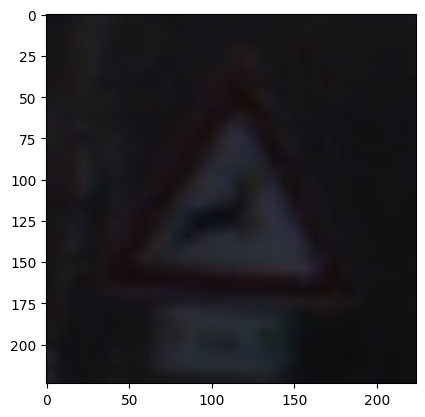

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = GhostNetV2(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
GhostNetV2                                                        --
├─Conv2dNormActivation: 1-1                                       --
│    └─Conv2d: 2-1                                                432
│    └─BatchNorm2d: 2-2                                           32
│    └─ReLU: 2-3                                                  --
├─Sequential: 1-2                                                 --
│    └─GhostLayerV2: 2-4                                          --
│    │    └─ResBlock: 3-1                                         1,008
│    └─GhostLayerV2: 2-5                                          --
│    │    └─ResBlock: 3-2                                         3,996
│    └─GhostLayerV2: 2-6                                          --
│    │    └─ResBlock: 3-3                                         5,328
│    └─GhostLayerV2: 2-7                                          --
│    │    └─ResBloc

# training

In [13]:
epoches = 10
acc_iters = 256 / BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion, scheduler)

100%|██████████| 416/416 [01:28<00:00,  4.69it/s]


epoch 1 : 0.00821402215940627


100%|██████████| 416/416 [01:24<00:00,  4.90it/s]


epoch 2 : 0.001515943864223328


100%|██████████| 416/416 [01:24<00:00,  4.90it/s]


epoch 3 : 0.00039134816275831184


100%|██████████| 416/416 [01:25<00:00,  4.87it/s]


epoch 4 : 0.00019887183431312503


100%|██████████| 416/416 [01:24<00:00,  4.92it/s]


epoch 5 : 0.0001441287818780578


100%|██████████| 416/416 [01:24<00:00,  4.91it/s]


epoch 6 : 0.00012392223624693507


100%|██████████| 416/416 [01:25<00:00,  4.86it/s]


epoch 7 : 0.00012088809765268357


100%|██████████| 416/416 [01:24<00:00,  4.92it/s]


epoch 8 : 7.493859497523877e-05


100%|██████████| 416/416 [01:24<00:00,  4.89it/s]


epoch 9 : 6.806774247536396e-05


100%|██████████| 416/416 [01:25<00:00,  4.89it/s]

epoch 10 : 6.459312867991028e-05


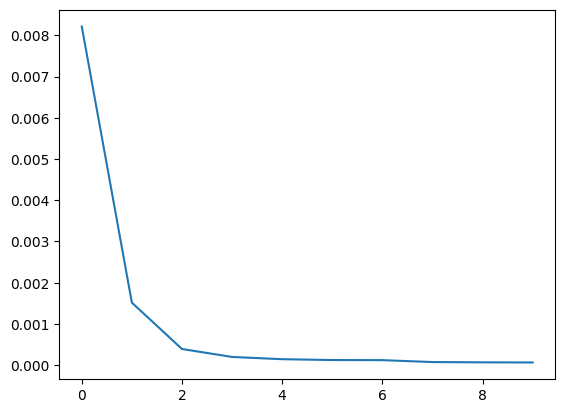

In [18]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [20]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:25<00:00,  7.91it/s]

[[ 57   0   0 ...   0   0   0]
 [  0 699   8 ...   0   0   0]
 [  0   2 744 ...   0   0   0]
 ...
 [  0   0   0 ...  89   0   0]
 [  0   0   0 ...   0  56   0]
 [  0   0   0 ...   0   5  83]]


In [24]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.95
1         : 0.9708333333333333
2         : 0.992
3         : 0.9844444444444445
4         : 0.9712121212121212
5         : 0.9412698412698413
6         : 0.8533333333333334
7         : 0.9355555555555556
8         : 0.9688888888888889
9         : 1.0
10        : 1.0
11        : 0.9809523809523809
12        : 0.946376811594203
13        : 0.9958333333333333
14        : 1.0
15        : 1.0
16        : 0.96
17        : 0.9194444444444444
18        : 0.9461538461538461
19        : 0.9666666666666667
20        : 0.43333333333333335
21        : 0.4888888888888889
22        : 0.925
23        : 0.9533333333333334
24        : 0.8333333333333334
25        : 0.8916666666666667
26        : 0.9277777777777778
27        : 0.5
28        : 0.9866666666666667
29        : 0.9666666666666667
30        : 0.6466666666666666
31        : 0.9925925925925926
32        : 1.0
33        : 0.9809523809523809
34        : 0.825
35        : 0.9948717948717949
36        : 0.9333333333333333
37        

In [25]:
per_class_acc.mean()

0.896331988125719

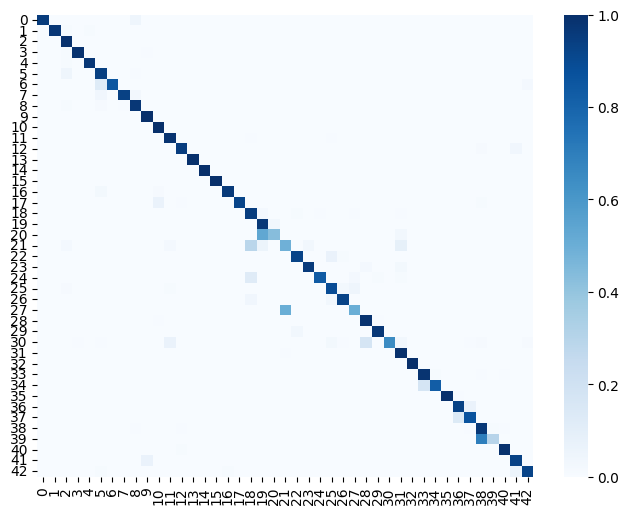

In [26]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [27]:
model_path = artifact_path / f'ghostnetv2.pth'

In [28]:
torch.save(model.state_dict(), model_path)

In [29]:
get_file_size(model_path)

'19.32MiB'

In [30]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>